In [1]:
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import nltk
import imageio
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics 
from sklearn.metrics import pairwise_distances 

from timeit import default_timer as timer
%matplotlib inline

import json as js

# How to Cluster

#### Go through the text and run the cells with ```shift+enter```

First check the folder you're working in:

In [2]:
pwd = !pwd

Remove the "*JupyterNotebook*"-part and save it to the `project_folder`-variable

In [3]:
project_folder = eval(re.sub('JupyterNotebook','',str(pwd)))[0]

In [4]:
project_folder

'/Users/matijaas/Documents/GitHub/ClusterDataIDS/'

Give here the same folder name you gave to `DataExtractor.sh`
> That's the folder that your refined data is in!

In [5]:
theName = 'testData'

Your `.csv`-file will be in path:

In [6]:
path2csv = project_folder + "{}/Data_Collection.csv".format(theName)
path2csv

'/Users/matijaas/Documents/GitHub/ClusterDataIDS/testData/Data_Collection.csv'

In [7]:
path2out = project_folder + "{}/outputs/".format(theName)
path2out

'/Users/matijaas/Documents/GitHub/ClusterDataIDS/testData/outputs/'

The `CollectAndSortFiles.sh`returns a number. Save it here

In [8]:
n_perm = 23            # Number of ways in which to combine the protonation states of the single molecules forming a neutral cluster

Run these to read the data in

In [9]:
def init_DF(csvfile):
    "Reads a xyz-file and initializes the dataframe."
    
    global n_atoms, atomnames
    
    filescsv = pd.read_csv(csvfile)                    # Read tthe .csv-file to a DataFrame
    xyz_temp = filescsv.iloc[0,2]                      # Get one .xyz-file as a reference
    
    xyz_test = read_xyz(xyz_temp,flatten=False)        # Read coordinates to a DF (no flattening)
    
    #filenames = filescsv.iloc[:,0]                    # Get the names for files as a Series (This one not used here)
    n_atoms = xyz_test.index.size                      # Number of atoms from the reference .xyz-file
    atomnames = np.array(xyz_test.index)               # Names of all the atoms as ndarray
    #np.save('{}{}/outputs/atomnames'.format(project_folder,theName),atomnames)                     # Save the atomnames for later use
    
    list_atomnames = []
    for i,j in enumerate(atomnames):                   # Give numbers for the atoms
        list_atomnames.append("{}_{}".format(j,i))
    arr_atomnames = np.array(list_atomnames)           # Enumerated atomnames as an ndarray
    
    col_names = makeMultiIndexs(arr_atomnames)         # Make column names (multi-index)

    arr_clusters,filenames = init_xyz_array(filescsv,n_atoms) # Read the actual coordinate data
    
    coord_df = pd.DataFrame(arr_clusters,index=filenames,columns=col_names) # Save the data in nice DF-fornat
    
    
    return coord_df

In [10]:
def init_xyz_array(filecsv, n_atoms):
    """Reads .xyz-file paths from .csv-file and returns 
    an array with all xyz-coords in rows, and the filenames for DF indexes"""
    
    arr_clusters = np.zeros((1,3*n_atoms+2))             # cols of coord array should be of shape [clusters,atoms*[x,y,z]]
    filenames = np.array(filecsv.Filename)               # Get the names of the clusters from the .csv-file

    for index, row in filecsv.iterrows():                # Iterate through clusters and save their attributes
        dipole = row.Dipole                              # find the dipole value
        energy = row.Energy                              # find the energy value
        metarr = np.array([energy,dipole])               # put dipole and energy to an array
        path = row.XYZPath                               # find the path for .xyz-file
        xyzs = read_xyz(path)                            # Read coordinates to an ndarray with flatten=True (default)

        #if index == None:                               # print stuff for debugging purposes of this function
        #    print("Filename:",filename)
        #    print("metarr:",metarr)
        #    print("shape:",metarr.shape)
        #    print("type:",type(metarr))
        #    print("path:",path)
        #    print("coordshape:",xyzs.shape)
        #    print("coords:",xyzs)
        
        arrr = np.array(list(metarr)+list(xyzs))         # concatenate one cluster info
        arr_clusters = np.vstack((arr_clusters,arrr))    # concatenate clusters to one array
    return arr_clusters[1:,:], filenames

In [11]:
def read_xyz(xyzfile,flatten=True):
    """
    usage: read_xyz(xyzfile,flatten(Default=True))
    
    Reads a xyz-file and returns the coordinates as DF
    or flattened to a Numpy-array
    """
    xyz_temp = pd.read_csv(xyzfile, \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)       # Reads coordinates from an xyz-file
    
    atoms3 = xyz_temp.shape[0]*3                          # multiply n of atoms with 3 dimensions
    
    if flatten==True:
        xyz_flat = xyz_temp.values.flatten().reshape(1,atoms3)#.astype(np.float)
        return xyz_flat[0]                                # returns coordinates as ndarray of shape [1,atoms*3]
    else:
        return xyz_temp                                   # returns coordinates as a DF

In [12]:
def makeMultiIndexs(arr):
    """
    Gets names of atoms as array and makes a pandas multi-indexing structure
    with x-, y- and z- columns for each atom.
    """
    top_arr = np.empty((arr.size * 3 +2)).astype(str)
    top_arr[0] = "Properties"
    top_arr[1] = "Properties"
    top_arr[2::3] = arr
    top_arr[3::3] = arr
    top_arr[4::3] = arr
    butt_arr = np.empty((arr.size * 3 +2)).astype(str)
    butt_arr[0] = "Energy"
    butt_arr[1] = "Dipole"
    butt_arr[2::3] = "x"
    butt_arr[3::3] = "y"
    butt_arr[4::3] = "z"
    col_arr = np.vstack((top_arr,butt_arr))
    #col_arr.transpose()
    col_arr_tuples = list(zip(*col_arr))
    col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
    return col_names

This one executes all functions above

In [13]:
clusters_df = init_DF(path2csv)

In [14]:
#from multi-index to one index
clusters_df.columns = ['_'.join(col) for col in clusters_df.columns.values]

In [15]:
energy=clusters_df['Properties_Energy']                                # %1 should take only the decimals
coord=clusters_df.drop(['Properties_Energy','Properties_Dipole'],1)    # dipoles and energy out

## Data exploration / EDA

Having a look on the distributions of the energy variable, it is asymmetric, with a tail on the right. 

Plot energy distribution

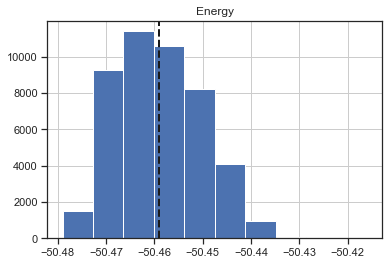

In [33]:
clusters_df['Properties_Energy'].hist()
plt.title("Energy")
plt.axvline(np.mean(clusters_df['Properties_Energy']), color='k', linestyle='dashed', linewidth=2)
plt.savefig("{}Energy_hist.png".format(path2out))

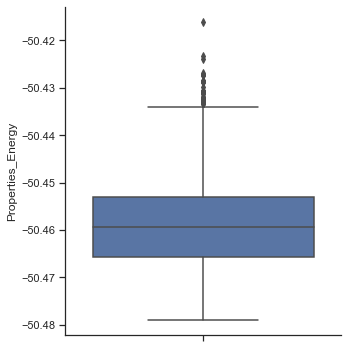

In [34]:
sns.catplot( y="Properties_Energy", kind="box", data=clusters_df)
plt.savefig("{}Energy_cat.png".format(path2out))

Difference between min and max energies is very small due to how ABCluster and XTB work.  
The algorithm in ABCluster tries to make the energies as small as possible.

Plot Energy and dipole and their correlation

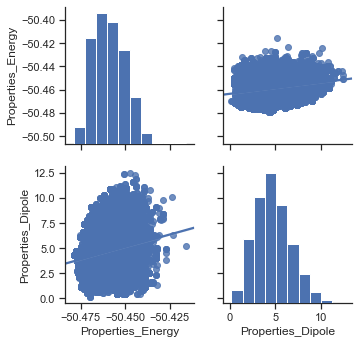

In [35]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(clusters_df,  kind="reg",vars=['Properties_Energy','Properties_Dipole'])

Energy and dipole propably don't have significant correlation

## Principal Component Analysis
The PCA is a tool used to reduce the dimensionality of the data.
It tries to preserve as much information as possible.  
These two goals in PCA are pursued by means of a transformation of the original variables into new variables, called Principal Components (PCs).  
They consists of a linear combination of the original variables.
PCs are uncorrelated and arranged in order of decreasing variance, so that the first PCs account for most of the variation in the sample.   

Next apply PCA to our **coordinates** variable, in order to select new variables, that explain at least 80% of the variability of our data.

In [19]:
pca = PCA(n_components=0.8,svd_solver='full')   # from docstring: this should include PCs so that 80% of variance is explained
PCs_coord = pca.fit_transform(coord)            # fit_transform on eri kun pelkkä transrofm
PCs_df = pd.DataFrame(data = PCs_coord, columns=["PC{}".format(i) for i in range(PCs_coord.shape[1])])
print('Explained variance :', np.sum(pca.explained_variance_ratio_)*100, '%')    # It seems that it is 80% :D

Explained variance : 80.21909698485128 %


Explained variance PC1 : 5.758731955517278 %
Explained variance PC2 : 5.449759951285701 %


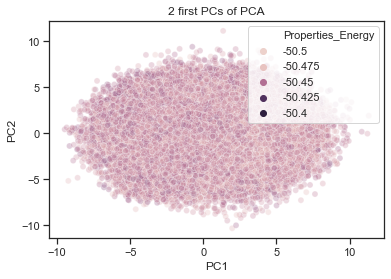

In [36]:
#2D graph of first two PCs
print('Explained variance PC1 :', pca.explained_variance_ratio_[0]*100, '%')
print('Explained variance PC2 :', pca.explained_variance_ratio_[1]*100, '%')

sns.scatterplot(x=PCs_df['PC1'], y=PCs_df['PC2'], hue=energy,  alpha=0.3)
plt.title("2 first PCs of PCA")
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

> Here $\uparrow$ could be some clustering seen but the representation as cartesian coordinates makes it challenging for machine to learn

## K-means / Clustering
In order to reduce the variety of our observations we are clustering our data, by using a k-mean algorith.  
This algorithm is a non-hierarchical methods of clustering, i.e. we assume the number $ k $ of groups is assumed to be fixed.
Algorithm introduced by MacQueen (1967): each statistical unit is assigned to the cluster whose centroid (i.e. vector of means) is the closest one. The metric used to measure the distance among groups is typically the Euclidean one.

#### Clustering with Coordinates as PCs

In [21]:
#clustering using PCS as variables
kmeans_PCs = KMeans(n_clusters=n_perm)
kmeans_PCs.fit(PCs_df)
PCs_kmeans = kmeans_PCs.predict(PCs_df)

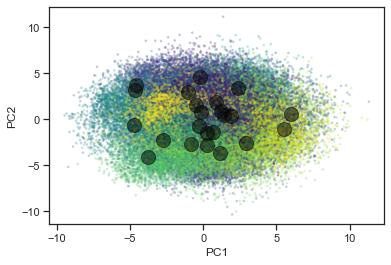

In [37]:
plt.scatter(PCs_df['PC1'], PCs_df['PC2'], c=PCs_kmeans,s=3, cmap='viridis', alpha=0.2)
centers_PCs = kmeans_PCs.cluster_centers_
plt.scatter(centers_PCs[:, 0], centers_PCs[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.savefig("{}clustered_PCs.png".format(path2out),dpi=300)
plt.show()

#### Clustering with coordinates as PCs and Energy

In [23]:
PCsE_df = pd.concat([PCs_df, clusters_df[['Properties_Energy']]], axis = 1)  
#finalDf = pd.concat([finalDf, clusters_df[['Properties_Dipole']]], axis = 1) # leave dipoles out

In [24]:
#clustering using PCS+E as variables
kmeans_PCE = KMeans(n_clusters=n_perm)
kmeans_PCE.fit(PCsE_df)
PCE_kmeans = kmeans_PCE.predict(PCsE_df)

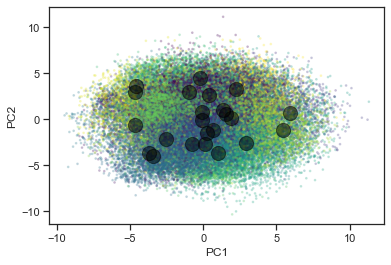

In [38]:
plt.scatter(PCsE_df['PC1'], PCsE_df['PC2'], c=PCE_kmeans,s=3, cmap='viridis', alpha=0.2)
centers_PCE = kmeans_PCE.cluster_centers_
plt.scatter(centers_PCE[:, 0], centers_PCE[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.savefig("{}clustered_PCsE.png".format(path2out),dpi=300)
plt.show()

#### Reversing the PCA will produce "average clusters" which correspond to the centroids of K-means -clusters

In [26]:
mu = np.mean(coord,axis=0)                      # calculate the average of the xyz coordinates
pca_rev = np.dot(centers_PCs,pca.components_)   # calculate a dot product between those things
for i in range(pca_rev.shape[0]):
    pca_rev[i,:] += mu                          # add the average
                                                # this is then the coordinates of the centers

In [27]:
stat_clusts_DF = pd.DataFrame(data=pca_rev,columns=clusters_df.columns[2:])

Here the average molecules are saved as `.npy`-files to the output-folder for later use.

In [28]:
for index,row in stat_clusts_DF.iterrows():
    row_arr = np.array(row).reshape((n_atoms,3))
    #np.save('{}{}/outputs/coord{}'.format(project_folder,theName,index),row_arr)   # Save the average coordinates for later use
    row_arr = np.column_stack((row_arr,atomnames))
    newperm = [3,0,1,2]
    avg_xyz = pd.DataFrame(row_arr[:,newperm],columns=['atom','x','y','z'])
    avg_xyz.to_csv("{}coord{}.xyz".format(path2out,index),sep='\t',index=False,header=[str(n_atoms),'','','\n'],quotechar=' ')

## t-SNE for visualizing the clusters better

The t-SNE produces clearer pictures of clustered material.

In [29]:
tsne_PCE = TSNE(n_components=2).fit_transform(PCsE_df)    # make t-SNE magic happen

In [30]:
tsne_PCE_cluster = pd.concat((pd.DataFrame(tsne_PCE,columns=['tsne1','tsne2']), pd.DataFrame(PCE_kmeans,columns=['groupID'])), axis = 1)  
# combine t-SNE info with the info of the cluster

In [31]:
centers_tSNE = tsne_PCE_cluster.groupby(by='groupID').mean()
# calculate the centers as means

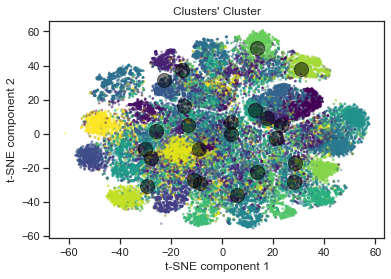

In [39]:
plt.scatter(tsne_PCE[:,0],tsne_PCE[:,1], c=PCE_kmeans,s=3, cmap='viridis', alpha=0.3)

plt.scatter(centers_tSNE.iloc[:, 0], centers_tSNE.iloc[:, 1], c='black', s=200, alpha=0.5)
plt.title("Clusters' Cluster")
plt.ylabel('t-SNE component 2')
plt.xlabel('t-SNE component 1')
plt.savefig("{}clustered_tsne.png".format(path2out),dpi=300)
plt.show()

***

***

#### Variables in this notebook

| Variable             | Usage                     | Data type   |
| :------------------- | :-----------------------  | :-----------|
| `project_folder`     | get the absolute path     | str         |
| `the_name`           | name of the data folder   | str         |
| `path2csv`           | to find the `.csv`-file   | DF          |
| `path2out`           | to put the outputs        | str         |
| `n_perm`             | number of permutations    | int         |
| `n_atoms`            | atoms in the clusters     | int         |
| `atomnames`          | atomnames from coords     | DF          |
| `clusters_df`        | Whole data                | DF          |
| `energy`             | energies col              | Series      |
| `coord`              | coordinate data           | DF          |
| `coord_train`        | x for training            | array       |
| `coord_test`         | x for testing             | array       |
| `energy_train`       | y for training            | array       |
| `energy_test`        | y for testing             | array       |
| `model`              | Linear Reg                | ***         |
| `r_sq`               | $ R^2 $-score             | float       |
| `energy_pred`        | predicted energies        | array       |
| `predictions`        | pred comparison           | DF          |
| `pca`                | PCA analysis obejct       | pca         |
| `PCs_coord`          | PCs of coordinates        | array?      |
| `PCs_df`             | PCs of coordinates        | DF          |
| `PCsE_df`            | PCs and energies          | DF          |
| `kmeans_ED`          | K-means object E+dipole   | kmeans      |
| `ED_kmeans_res`      | K-means prediction        | array       |
| `centers_ED`         | E+dipol centers for plot  | array       |
| `kmeans_PCs`         | K-means object PCA        | kmeans      |
| `PCs_kmeans`         | K-means pred from PCs     | array       |
| `centers_PCs`        | PCs centers for plot      | array       |
| `kmeans_PCE`         | K-means object PCs+E      | kmeans      |
| `PCE_kmeans`         | K-means pred from PCs+E   | array       |
| `centers_PCE`        | E+PCA centers for plot    | array       |
| `mu`                 | mean for PCA rev          | float       |
| `pca_rev`            | avg coords from PCA rev   | array       |
| `stat_clusts_DF`     | avg coords as DF          | DF          |
| `row_arr`            | one coord in loop         | array       |
| `avg_xyz`            | `row_arr` ordered to save | DF          |
| `k_values`           | look for optimal n_clusts | array       |
| `ch_values`          | calinski-harabasz scores  | array       |
| `k_best`             | the best amount of clusts | int         |
| `kbest_PCE`          | K-means PCs+E /w k_best   | kmeans      |
| `PCE_kbest`          | pred from PCs+E (k_best)  | array       |
| `centers_kbest`      | E+PCA centers /w k_best   | array       |
| `tsne_PCE`           | t_SNE for PCs+E           | array       |
| `tsne_PCE_cluster`   | t_SNE + groupID           | array       |
| `centers_tSNE`       | E+PCA centers for t-SNE   | array       |


***